<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/Pattern_recognition_spr_2022/blob/main/Diaphanoscopy_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Установка библиотек

In [136]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

**Импорт библиотек**

In [137]:
from fastai.vision.all import *

#Загрузка данных и формирование датасета

In [138]:
#path =  Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Bears')
path = Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy')

In [139]:
path.ls()

(#2) [Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy/Patients'),Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy/Healthy')]

Считывание адресов файлов изображений

In [140]:
files = get_image_files(path)

In [141]:
len(files)

54

In [142]:
files[0],files[2]

(Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy/Patients/1_650_L40.bmp'),
 Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy/Patients/3_650_L41.bmp'))

**Создание датасета**

Используется DataBlock и DataLoader. Разметка данных осуществляется по названиям папок с помощью функции parent_label.



In [149]:
ds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.25,seed=42),
    get_y=parent_label)

Аугментация данных
 https://docs.fast.ai/vision.augment.html

In [150]:
#??aug_transforms

In [151]:
ds = ds.new(item_tfms=RandomResizedCrop(128, min_scale=0.6),
            batch_tfms=aug_transforms(mult=1, do_flip=False, max_lighting=0.3, max_warp=0.1))

Загрузка данных

In [152]:
#??DataBlock.dataloaders

In [153]:
dls = ds.dataloaders(path,bs=34,shuffle=True)

Просмотр примера изображений

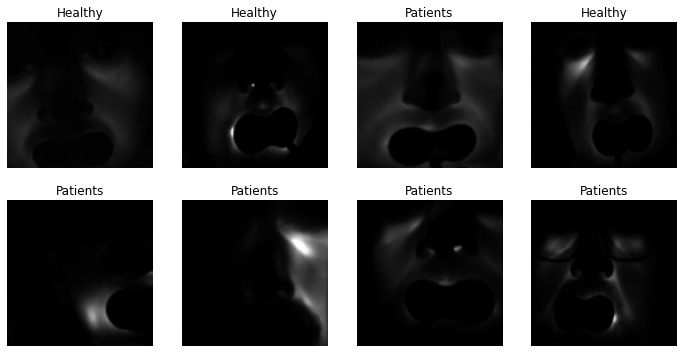

In [154]:
dls.show_batch(max_n=8, nrows=2, unique=False)

#Обучение

In [155]:
#??cnn_learner

In [156]:
learn = cnn_learner(dls,resnet34,metrics=error_rate,pretrained=True,lr=1e-4)

Целевая функция

In [157]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Метод поиска экстремума

In [158]:
learn.opt_func

<function fastai.optimizer.Adam>

Подбор скорости обучения. Строку ниже можно закоментировать. 

In [159]:
# hide
#learn.lr_find()

In [160]:
learn.fine_tune(45)

epoch,train_loss,valid_loss,error_rate,time
0,1.192027,0.886972,0.307692,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.589775,0.932580,0.384615,00:02
1,0.833589,0.945716,0.384615,00:02
2,0.737357,0.899338,0.384615,00:02
3,0.782723,0.866502,0.384615,00:02
4,0.747861,0.879253,0.384615,00:02
5,0.813861,0.941849,0.384615,00:02
6,0.775656,0.985493,0.384615,00:02
7,0.745740,0.994010,0.384615,00:02
8,0.728974,1.012089,0.384615,00:02
9,0.693750,1.039548,0.384615,00:02


#Результаты

Предсказание для любого конкретного изображения

In [161]:
learn.predict(files[21]), files[21]

(('Healthy', TensorBase(0), TensorBase([9.9999e-01, 1.3220e-05])),
 Path('/content/gdrive/MyDrive/work/Pattern recognition/Practice_Diaphanoscopy/Healthy/1_650_L01.bmp'))

Визуализация предсказаний.

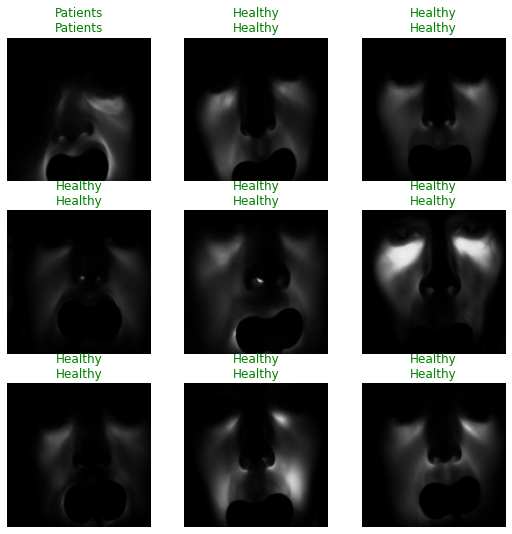

In [162]:
learn.show_results()

Визуализация топа ошибок.

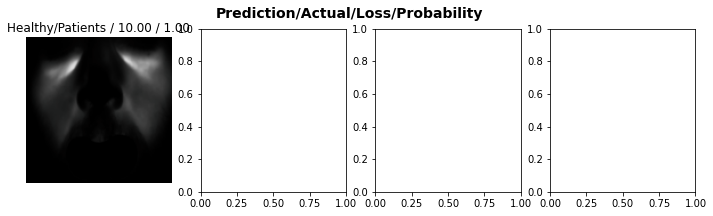

In [163]:
interp.plot_top_losses(4, nrows=1)

**Оценка точности**

Матрица ошибок

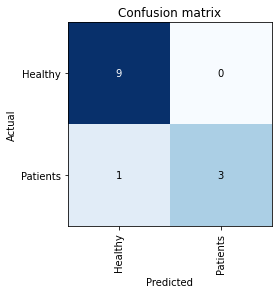

In [164]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [165]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

9 0 1 3


In [166]:
sensitivity = tp/(tp + fn)
sensitivity

0.75

Специфичность

In [167]:
specificity = tn/(fp + tn)
specificity

1.0

Positive Predictive Value (PPV)

In [168]:
ppv = tp/(tp+fp)
ppv

1.0

Negative Predictive Value (NPV)

In [169]:
npv = tn/(tn+fn)
npv

0.9

Calculating Accuracy

In [170]:
acc = (tp+tn)/(tp+tn+fp+fn)
acc

0.9230769230769231

#Сохранение и повторное использование

From the book:
Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call export, fastai will save a file called "export.pkl":

Сохранение обученной сети

In [171]:
learn.export()

Проверка результатов сохранения

In [172]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Использование обученной сети для предсказаний на новых данных. 

In [173]:
learn_inf = load_learner(path/'export.pkl')

In [174]:
files_test = get_image_files(path/'Test')

NameError: ignored

In [ ]:
len(files_test)

Предсказание на тестовых изображениях

Одно изображение

In [ ]:
learn_inf.predict(files_test[0])

Вся папка

In [ ]:
def func_accuracy(files_test):
  tp, tn, fp, fn, acc = 0, 0, 0, 0, 0
  feed = [0]*len(files_test)
  pred = [0]*len(files_test)
  gtrue = [0]*len(files_test)
  labels_voc = learn_inf.dls.vocab # labels
  for ind, o in enumerate(files_test):
    feed[ind] = learn_inf.predict(o)
    pred[ind] = labels_voc[feed[ind][-1].argmax()]
    gtrue[ind] =feed[ind][0]
    acc += int(gtrue[ind] == pred[ind])
    #print(gtrue[ind], pred[ind])
  return acc/len(files_test)

In [ ]:
func_accuracy(files_test)

#Ссылки



https://github.com/avkornaev/Fast_AI_course/blob/main/02_production_v3_online.ipynb

https://docs.fast.ai/tutorial.medical_imaging.html

https://docs.fast.ai/data.block.html#DataBlock


